In [2]:
from autoencoder import AutoEncoder
import pandas as pd
import numpy as np

In [53]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from scipy.sparse import coo_matrix

In [129]:
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
def mask_sample(tensor: torch.Tensor, mask_fraction: float, device: torch.device):
    tensor = tensor.to(device)
    masked_tensor = tensor.clone()

    # Identify non-zero elements in the tensor
    non_zero_indices = (tensor != 0).nonzero(as_tuple=False)

    # Determine the number of elements to mask
    num_non_zeros = non_zero_indices.size(0)
    num_to_mask = int(mask_fraction * num_non_zeros)

    if num_to_mask > 0:
        # Randomly select indices to mask
        mask_indices = torch.randperm(num_non_zeros)[:num_to_mask]

        # Apply the mask
        masked_tensor[non_zero_indices[mask_indices, 0], non_zero_indices[mask_indices, 1]] = 0

    return masked_tensor

In [ ]:
def test_sample_model(model: AutoEncoder, sample:pd.DataFrame, device: torch.device):
    model.eval()
    sample_coo = coo_matrix(sample.values)
    
    # Convert the COO matrix to a dense tensor
    sample_tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)

    
    # Test the model on each row of the sample
    # tested = sample.apply(lambda row: mask_test_model(model, 0.2, torch.tensor(row.to_numpy(), dtype=torch.float32, device=device), device)[0], axis=1)
    masked_test = mask_sample(sample_tensor, 0.2, device)
    

    tested_df = pd.DataFrame(index=sample.index, columns=sample.columns)

    result = model(masked_test)

    for i, j in zip(sample_coo.row, sample_coo.col):
        tested_df.iloc[i, j] = result[i, j].item()

    # Calculate the Frobenius norm of the difference
    # calculate the rmse
    
    # loss = linalg.norm(sample.to_numpy() - tested.to_numpy().T, ord='fro')
    mse = np.mean((sample.to_numpy() - result.cpu().detach().numpy())**2)
    loss = np.sqrt(mse)
    
    return loss, tested_df.T, sample

In [154]:
np.random.seed(42)
torch.manual_seed(42)

# Create a user-item interaction matrix (100 users, 50 items) with sparsity
num_users = 10000
num_items = 500
interaction_matrix = np.random.randint(0, 6, size=(num_users, num_items))  # Random interactions from 0 to 5

# Introduce sparsity by setting a high percentage of interactions to 0
sparsity = 0.8  # 80% of the interactions will be set to 0
mask = np.random.rand(*interaction_matrix.shape) < sparsity
interaction_matrix[mask] = 0
interaction_matrix

array([[3, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 5],
       ...,
       [1, 0, 0, ..., 0, 0, 5],
       [0, 0, 2, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [155]:
coo = coo_matrix(interaction_matrix, (num_users, num_items))
dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
dataset = TensorDataset(dense_matrix)
bottleneck_size = 32
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [156]:
model = AutoEncoder(num_items, bottleneck_size, device=device).to(device)

Epoch [1/1000], Loss: 1.6104
Epoch [2/1000], Loss: 1.5616
Epoch [3/1000], Loss: 1.5416
Epoch [4/1000], Loss: 1.5242
Epoch [5/1000], Loss: 1.5110
Epoch [6/1000], Loss: 1.5018
Epoch [7/1000], Loss: 1.4948
Epoch [8/1000], Loss: 1.4899
Epoch [9/1000], Loss: 1.4867
Epoch [10/1000], Loss: 1.4816
Epoch [11/1000], Loss: 1.4777
Epoch [12/1000], Loss: 1.4754
Epoch [13/1000], Loss: 1.4703
Epoch [14/1000], Loss: 1.4676
Epoch [15/1000], Loss: 1.4645
Epoch [16/1000], Loss: 1.4616
Epoch [17/1000], Loss: 1.4591
Epoch [18/1000], Loss: 1.4571
Epoch [19/1000], Loss: 1.4561
Epoch [20/1000], Loss: 1.4553
Epoch [21/1000], Loss: 1.4543
Epoch [22/1000], Loss: 1.4532
Epoch [23/1000], Loss: 1.4529
Epoch [24/1000], Loss: 1.4520
Epoch [25/1000], Loss: 1.4521
Epoch [26/1000], Loss: 1.4513
Epoch [27/1000], Loss: 1.4508
Epoch [28/1000], Loss: 1.4502
Epoch [29/1000], Loss: 1.4500
Epoch [30/1000], Loss: 1.4499
Epoch [31/1000], Loss: 1.4476
Epoch [32/1000], Loss: 1.4474
Epoch [33/1000], Loss: 1.4463
Epoch [34/1000], Lo

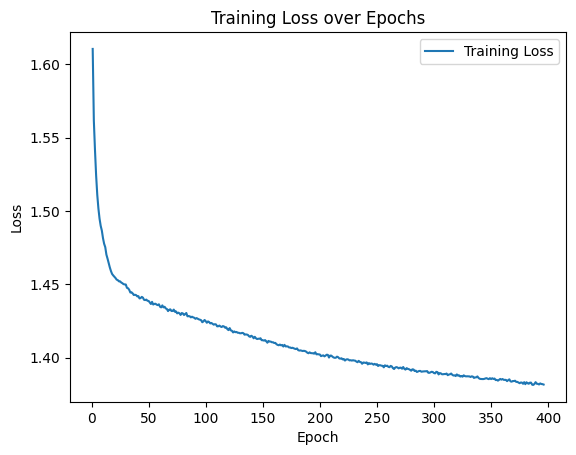

In [157]:
# Train the model
epochs, epoch_losses = model.fit(train_loader, n_epochs=1000, lr=0.001, patience=10)

# Plot the training loss over epochs
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [164]:
res = test_sample_model(model, interaction_matrix, device)
res[1]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.474649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.652045,NaN,NaN,0.560688,NaN,NaN,0.880168,0.558069,NaN,NaN
1,NaN,1.155326,NaN,0.323763,2.216443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.621756,NaN,NaN,0.636693,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.838041,NaN,NaN,NaN,NaN,0.24753,0.945986,...,NaN,NaN,0.943234,NaN,0.521716,NaN,NaN,NaN,0.397425,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262663,NaN,...,NaN,NaN,0.099641,0.30281,0.199142,NaN,NaN,0.217982,NaN,5.779841
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.148624,NaN,NaN,NaN,0.811935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,0.676437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.822026,NaN,NaN
496,NaN,1.107556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404543,...,NaN,NaN,NaN,NaN,NaN,NaN,0.225224,NaN,NaN,NaN
497,NaN,NaN,NaN,1.322971,NaN,NaN,NaN,NaN,NaN,0.384123,...,NaN,0.681238,NaN,NaN,NaN,0.610057,0.690279,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.500667,NaN,NaN,NaN,0.105736,NaN


In [166]:
res[0]

0.04205758656778135

In [99]:
from scipy.sparse import coo_matrix

In [117]:
coo = coo_matrix(interaction_matrix, (num_users, num_items))
dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
dataset = TensorDataset(dense_matrix)
bottleneck_size = 32
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [118]:
model = AutoEncoder(num_items, bottleneck_size, device=device).to(device)

In [128]:
bottleneck_size = 32

In [135]:
training = False

In [136]:
generate_data = False

In [137]:
if generate_data:
	sample = pd.read_csv('predictions.csv')
	res = { k: v.get(["book_id", "rating"]) for k, v in sample.groupby('user_id')}
	sample_matrix = pd.DataFrame(index= res.keys(), columns = sample['book_id'].unique())
	sample_matrix.to_csv('sample_matrix.csv.gzip', index=True, columns=sample_matrix.columns, chunksize=1000, compression='gzip')
	for k, v in res.items():
		t = v.reset_index(drop=True).transpose()
		sample_matrix.loc[k][t.loc["book_id"]] = t.loc["rating"]
else:
	sample_matrix = pd.read_csv('sample_matrix.csv.gzip', compression='gzip', index_col=0)

In [138]:
if not training:
	model = torch.load(f'sample_model/sample_model_k={bottleneck_size}.pt')
	model.load_state_dict(torch.load(f'sample_model/sample_model_k_weights_{bottleneck_size}.pt'))
else:
	coo = coo_matrix(sample_matrix.T.to_numpy(), (sample_matrix.shape[1], sample_matrix.shape[0]))
	dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
	dataset = TensorDataset(dense_matrix)
	
	batch_size = 128
	batches = DataLoader(dataset, batch_size=batch_size, shuffle=True)
	epochs, losses = model.fit(batches, n_epochs=1000, lr=0.001, patience=10)

	pd.DataFrame({"epochs": epochs, "training losses": losses}).to_csv(f'sample_model/{bottleneck_size}.csv')
	torch.save(model, f'sample_model/sample_model_k={bottleneck_size}.pt')
	torch.save(model.state_dict(), f'sample_model/sample_model_k_weights_{bottleneck_size}.pt')

In [132]:
def mask_row(row: torch.Tensor, mask_fraction: float, device: torch.device):
    # Identify non-zero elements in the row
    non_zero_indices = row.nonzero(as_tuple=True)[0]

    # Create a mask for the non-zero elements
    mask = torch.rand(len(non_zero_indices)).to(device) < mask_fraction

    # Apply the mask to the row
    masked_row = row.clone().to(device)
    masked_row[non_zero_indices[mask]] = 0

    return masked_row



In [95]:
result = test_sample_model(model, sample_matrix.T, device)[1].T

In [78]:
# filter out values that are less than the threshold of 0.1
result2 = result.applymap(lambda x: x if x > 0.1 else 0)

/var/folders/rg/cmtcr_3n3g5bk2x49f7jdpdw0000gn/T/ipykernel_30049/2631893220.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result2 = result.applymap(lambda x: x if x > 0.1 else 0)


In [121]:
result

,0743491912,4770021224,0691001286,B0007PC4W0,B000MCASDU,1410400069,B0007IVSYM,0886776538,B000GQFL9S,B0000YSH38,...,B0007GUR5K,0764304836,0553286110,B000MZQ8MC,0743418557,0809144204,B000HWYVRO,B000KPYGY6,0312317425,029784699X
A101446I5AWY0Z,0.000349,-0.000310,-0.000061,0.000487,-0.000201,0.000426,0.000684,-0.000016,-0.001582,-0.002015,...,-0.000041,-0.000041,-0.000028,-0.000175,0.000130,0.000032,-0.000041,-0.000041,0.000464,-0.000039
A103U0Q3IKSXHE,-0.001134,-0.001410,-0.001059,0.000238,-0.000893,-0.000102,-0.001390,-0.001010,0.004501,0.009102,...,-0.000960,-0.000960,-0.000970,-0.001105,0.000364,-0.000466,-0.000960,-0.000960,0.000344,-0.000946
A103W7ZPKGOCC9,0.000392,0.000063,0.000009,0.000181,0.000115,0.000160,-0.000124,0.000022,0.000056,0.001787,...,0.000008,0.000008,0.000021,0.000075,-0.000011,0.000557,0.000008,0.000008,0.000196,0.000010
A105E427BB6J65,0.000559,0.001610,0.001254,-0.002803,0.002059,-0.001107,-0.000113,0.001286,0.000362,0.001230,...,0.001387,0.001387,0.001409,0.000944,0.001058,0.002746,0.001387,0.001387,-0.002624,0.001399
A106016KSI0YQ,0.000483,0.001286,0.001304,-0.000786,0.001376,-0.000316,0.001077,0.000663,0.009742,-0.011529,...,0.000738,0.000738,0.000780,-0.000120,0.005414,0.001646,0.000738,0.000738,-0.000955,0.000797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZXEZRXZQL1H2,0.005082,0.007064,0.006950,-0.008673,0.005861,-0.008936,0.004446,0.006579,-0.000216,-0.026378,...,0.006473,0.006473,0.006517,0.006463,0.004413,0.003325,0.006473,0.006473,-0.008177,0.006487
AZXGPM8EKSHE9,0.000819,-0.000057,0.000127,0.000601,0.000058,0.000514,0.000756,0.000114,-0.000525,-0.002694,...,0.000101,0.000101,0.000112,0.000013,0.000158,0.000214,0.000101,0.000101,0.000566,0.000109
AZXQKAMHK35PA,0.003607,-0.000411,-0.000931,-0.000878,-0.000009,0.001034,0.000976,-0.000632,0.008903,0.006263,...,-0.000651,-0.000651,-0.000673,-0.000488,0.003923,0.005709,-0.000651,-0.000651,-0.000956,-0.000667
AZY8LGHVF8GMZ,-0.001205,0.000190,-0.000027,0.000819,0.000135,0.001609,-0.000992,-0.000093,0.005292,0.000606,...,-0.000041,-0.000041,-0.000065,0.000022,-0.000526,-0.000252,-0.000041,-0.000041,0.001039,-0.000067


In [98]:
# rows and columns that are not zero
result['B00086PL00'][result['B00086PL00'] > 0.01]

A10A1S5NAQBT21    0.011993
A11GO5VA74HD8K    0.010153
A12A08OL0TZY0W    0.019975
A13F2IV3ME23R     0.044718
A14OJS0VWMOSWO    0.020910
                    ...   
AUM3YMZ0YRJE0     0.016829
AVXXGV0UD721E     0.011293
AW1D2TDTE17QL     0.020270
AWLFVCT9128JV     0.013132
AYHVXPT15XU66     0.014390
Name: B00086PL00, Length: 155, dtype: float32